In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path =  "/content/drive/My Drive/KhoaLuan/"

In [ ]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, logging

import warnings
import time
import pickle
warnings.filterwarnings("ignore")

logging.set_verbosity_error()

In [ ]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

seed_everything(86)

In [ ]:
model_name = "bluenguyen/longformer-phobert-base-4096"  # vinai/phobert-base-v2
max_len = 512   # 256
n_classes = 13
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)

tokenizer_config.json:   0%|          | 0.00/311 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
EPOCHS = 5
N_SPLITS = 5

## Data

### Get data

In [ ]:
# Function to read data from JSON file
def get_data(path):
    df = pd.read_json(path, lines=True)
    return df

TRAIN_PATH = path + "train_data_162k.json"
TEST_PATH = path + "test_data_162k.json"
VAL_PATH = path + "val_data_162k.json"

# Read the data from JSON files
train_df = get_data(TRAIN_PATH)
test_df = get_data(TEST_PATH)
valid_df = get_data(VAL_PATH)

# Combine train and validation data
train_df = pd.concat([train_df, valid_df], ignore_index=True)

# Apply StratifiedKFold
skf = StratifiedKFold(n_splits=N_SPLITS)
for fold, (_, val_) in enumerate(skf.split(X=train_df, y=train_df.category)):
    train_df.loc[val_, "kfold"] = fold

In [ ]:
train_df.sample(5)

,category,processed_content,kfold
96994,Xe co,fiat giới_thiệu động_cơ siêu_sạch air triển_lã...,3.0
22834,Phap luat,cận_cảnh hiện_trường quán karaoke xảy vụ bắn c...,1.0
14391,Nha dat,thổi giá kích_cầu đợt ấm đột_biến thị_trường đ...,2.0
100151,Xa hoi,quảng_ninh người_dân nuôi ngao run phóng_viên ...,0.0
31397,Giao duc,hội tư_vấn xét tuyển đại_học cao_đẳng diễn onl...,1.0


In [ ]:
train_df.info(), test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138223 entries, 0 to 138222
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   category           138223 non-null  object 
 1   processed_content  138223 non-null  object 
 2   kfold              138223 non-null  float64
dtypes: float64(1), object(2)
memory usage: 3.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24126 entries, 0 to 24125
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   category           24126 non-null  object
 1   processed_content  24126 non-null  object
dtypes: object(2)
memory usage: 377.1+ KB


(None, None)

### Distribution of Categories

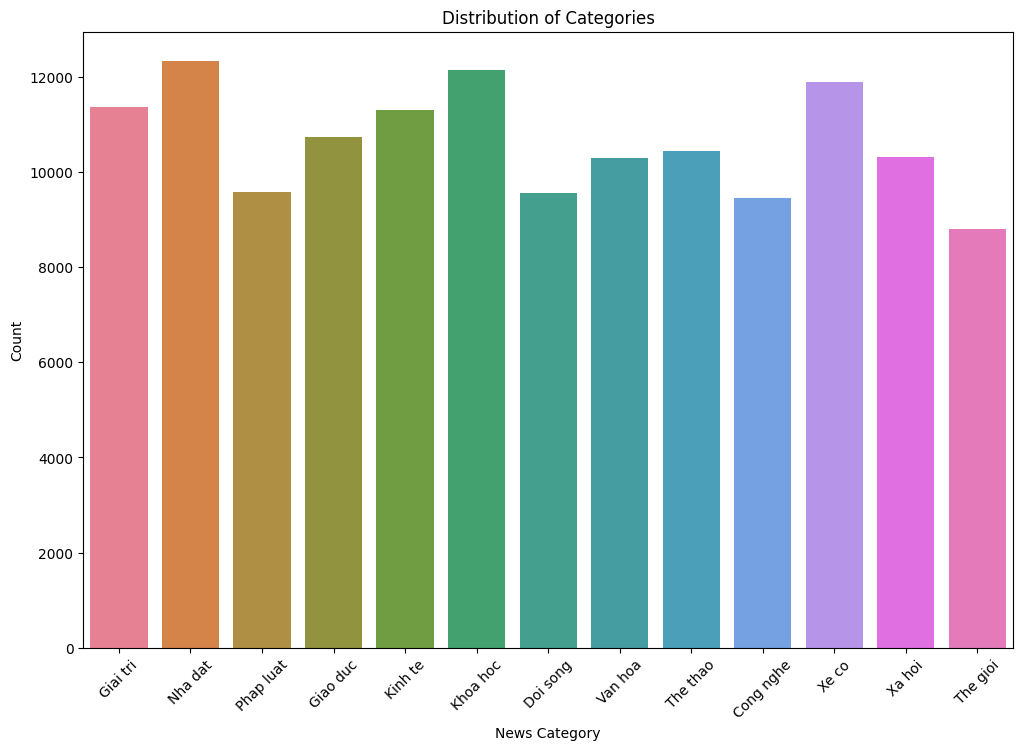

In [ ]:
# Plotting with Seaborn
plt.figure(figsize=(12, 8))

# Get the unique categories
news_categories = train_df['category'].unique()

colors = sns.color_palette("husl", len(news_categories))

color_mapping = {article: colors[i] for i, article in enumerate(news_categories)}

# Plot with each bar having a different color
ax = sns.countplot(x='category', data=train_df, palette=color_mapping)

# Add title and labels
plt.title('Distribution of Categories')
plt.xlabel('News Category')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x labels for better readability

# Display the plot
plt.show()

### Distribution of length of Sentence

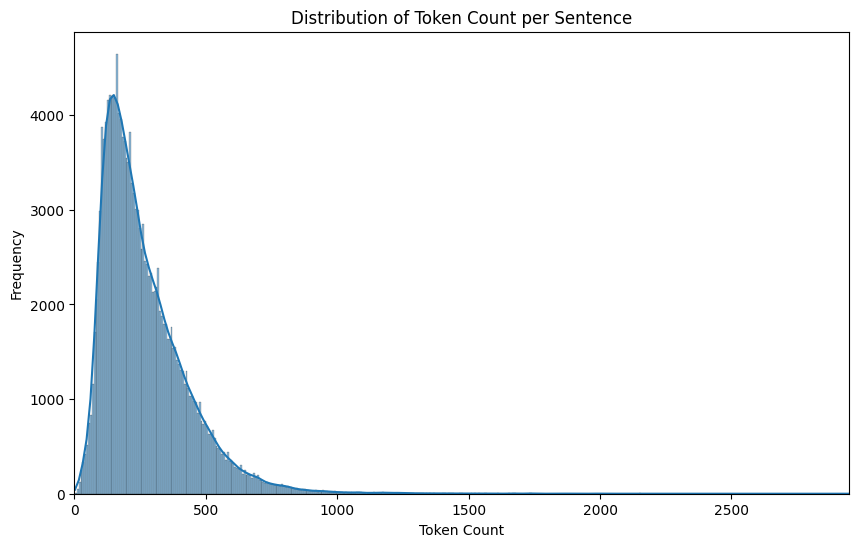

In [ ]:

# Combine processed content from train and test dataframes
all_data = train_df.processed_content.tolist() + test_df.processed_content.tolist()
# Encode the text
encoded_text = [tokenizer.encode(text, add_special_tokens=True) for text in all_data]

# Calculate the length of each encoded text
token_lens = [len(text) for text in encoded_text]

# Plot the distribution of token lengths
plt.figure(figsize=(10, 6))
sns.histplot(token_lens, kde=True)
plt.xlim([0, max(token_lens)])
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.title('Distribution of Token Count per Sentence')
plt.show()

## Model PhoBert

In [ ]:
class NewsDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.max_len = max_len
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        """
        To customize dataset, inherit from Dataset class and implement
        __len__ & __getitem__
        __getitem__ should return
            data:
                input_ids
                attention_masks
                text
                targets
        """
        row = self.df.iloc[index]
        text, label = self.get_input_data(row)

        # Encode_plus will:
        # (1) split text into token
        # (2) Add the '[CLS]' and '[SEP]' token to the start and end
        # (3) Truncate/Pad sentence to max length
        # (4) Map token to their IDS
        # (5) Create attention mask
        # (6) Return a dictionary of outputs
        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_masks': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long),
        }


    def labelencoder(self, text):
        label_map = {
            'Cong nghe': 0, 'Doi song': 1, 'Giai tri': 2, 'Giao duc': 3, 'Khoa hoc': 4,
            'Kinh te': 5, 'Nha dat': 6, 'Phap luat': 7, 'The gioi': 8, 'The thao': 9,
            'Van hoa': 10, 'Xa hoi': 11, 'Xe co': 12
        }
        return label_map.get(text, -1)

    def get_input_data(self, row):
        text = row['processed_content']
        label = self.labelencoder(row['category'])
        return text, label

In [ ]:
class NewsClassifier(nn.Module):
    def __init__(self, n_classes, model_name):
        super(NewsClassifier, self).__init__()
        # Load a pre-trained BERT model
        self.bert = AutoModel.from_pretrained(model_name)
        # Dropout layer to prevent overfitting
        self.drop = nn.Dropout(p=0.3)
        # Fully-connected layer to convert BERT's hidden state to the number of classes to predict
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
        # Initialize weights and biases of the fully-connected layer using the normal distribution method
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)

    def forward(self, input_ids, attention_mask):
        # Get the output from the BERT model
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False
        )
        # Apply dropout
        x = self.drop(output)
        # Pass through the fully-connected layer to get predictions
        x = self.fc(x)
        return x

In [ ]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)

    train_dataset = NewsDataset(df_train, tokenizer, max_len)
    valid_dataset = NewsDataset(df_valid, tokenizer, max_len)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
    valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True, num_workers=2)

    return train_loader, valid_loader

### Train

In [ ]:
# Function to train the model for one epoch
def train(model, criterion, optimizer, train_loader, lr_scheduler):
    model.train()
    losses = []
    correct = 0

    for batch_idx, data in enumerate(train_loader):
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        loss = criterion(outputs, targets)
        _, pred = torch.max(outputs, dim=1)

        correct += torch.sum(pred == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()

        if batch_idx % 1000 == 0:
            print(f'Batch {batch_idx}/{len(train_loader)} - Loss: {loss.item():.4f}, Accuracy: {correct.double() / ((batch_idx + 1) * train_loader.batch_size):.4f}')

    train_accuracy = correct.double() / len(train_loader.dataset)
    avg_loss = np.mean(losses)
    print(f'Train Accuracy: {train_accuracy:.4f} Loss: {avg_loss:.4f}')

# Function to evaluate the model
def eval(model, criterion, valid_loader, test_loader=None):
    model.eval()
    losses = []
    correct = 0

    with torch.no_grad():
        data_loader = test_loader if test_loader else valid_loader
        for batch_idx, data in enumerate(data_loader):
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_masks'].to(device)
            targets = data['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            loss = criterion(outputs, targets)
            _, pred = torch.max(outputs, dim=1)

            correct += torch.sum(pred == targets)
            losses.append(loss.item())

    dataset_size = len(test_loader.dataset) if test_loader else len(valid_loader.dataset)
    accuracy = correct.double() / dataset_size
    avg_loss = np.mean(losses)

    if test_loader:
        print(f'Test Accuracy: {accuracy:.4f} Loss: {avg_loss:.4f}')
    else:
        print(f'Valid Accuracy: {accuracy:.4f} Loss: {avg_loss:.4f}')

    return accuracy


total_start_time = time.time()

# Main training loop
for fold in range(skf.n_splits):
    print(f'----------- Fold: {fold + 1} ------------------')
    train_loader, valid_loader = prepare_loaders(train_df, fold=fold)
    model = NewsClassifier(n_classes=13).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=2e-5)

    lr_scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=len(train_loader) * EPOCHS
    )
    best_acc = 0

    for epoch in range(EPOCHS):
        print(f'Epoch {epoch + 1}/{EPOCHS}')
        print('-' * 30)

        train(model, criterion, optimizer, train_loader, lr_scheduler)
        val_acc = eval(model, criterion, valid_loader)

        if val_acc > best_acc:
            torch.save(model.state_dict(), f'phobert_fold{fold + 1}.pth')
            best_acc = val_acc
        print(f'Best Accuracy for Fold {fold + 1}: {best_acc:.4f}')
        print()
    print(f'Finished Fold {fold + 1} with Best Accuracy: {best_acc:.4f}')
    print('--------------------------------------')


total_end_time = time.time()

total_duration = total_end_time - total_start_time
print(f'Total training time: {total_duration:.2f} seconds')


### Test

In [ ]:
# Function to decode numeric labels into their corresponding text names
def decode_labels(labels):
    label_map = {
        0: 'Cong nghe', 1: 'Doi song', 2: 'Giai tri', 3: 'Giao duc', 4: 'Khoa hoc',
        5: 'Kinh te', 6: 'Nha dat', 7: 'Phap luat', 8: 'The gioi', 9: 'The thao',
        10: 'Van hoa', 11: 'Xa hoi', 12: 'Xe co'
    }
    return [label_map[label] for label in labels]

# Function to test the model
def test(data_loader):
    models = []
    for fold in range(skf.n_splits):
        model = NewsClassifier(n_classes=13)
        model.to(device)
        model.load_state_dict(torch.load(f'{path}phobert_fold{fold+1}.pth'))
        model.eval()
        models.append(model)

    texts = []
    predicts = []
    predict_probs = []
    real_values = []

    for data in data_loader:
        text = data['text']
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        total_outs = []
        for model in models:
            with torch.no_grad():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                total_outs.append(outputs)

        # Taking the average of predictions from 5 models
        total_outs = torch.stack(total_outs)
        _, pred = torch.max(total_outs.mean(0), dim=1)
        texts.extend(text)
        predicts.extend(pred)
        predict_probs.extend(total_outs.mean(0))
        real_values.extend(targets)

    predicts = torch.stack(predicts).cpu().numpy()
    predict_probs = torch.stack(predict_probs).cpu().numpy()
    real_values = torch.stack(real_values).cpu().numpy()

    # Decode numeric labels into text labels
    decoded_real_values = decode_labels(real_values)
    decoded_predicts = decode_labels(predicts)

    # Generate classification report
    report = classification_report(decoded_real_values, decoded_predicts, output_dict=True)

    # Convert to DataFrame
    df_report = pd.DataFrame(report).transpose()

    return df_report, real_values, predicts

In [ ]:
# Create dataloader for test set
test_dataset = NewsDataset(test_df, tokenizer, max_len)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)
df_report, real_values, predicts = test(test_loader)

config.json:   0%|          | 0.00/916 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/637M [00:00<?, ?B/s]

In [ ]:
df_report

,precision,recall,f1-score,support
Cong nghe,0.943223,0.942648,0.942936,1639.000000
Doi song,0.891596,0.882459,0.887004,1659.000000
Giai tri,0.932446,0.931493,0.931969,1956.000000
Giao duc,0.927056,0.945148,0.936015,1896.000000
Khoa hoc,0.900331,0.905463,0.902890,2105.000000
Kinh te,0.913934,0.876228,0.894684,2036.000000
Nha dat,0.910014,0.921926,0.915931,2139.000000
Phap luat,0.903488,0.894646,0.899045,1737.000000
The gioi,0.932762,0.935847,0.934302,1512.000000
The thao,0.965831,0.982619,0.974153,1726.000000


In [ ]:
df_report.to_csv(path + 'classification_report_longformer.csv', index=True) # classification_report_phobertbase.csv
data_to_save = [real_values, predicts]


with open(path + 'real_values_and_predicts_longformer.pkl', 'wb') as f: # real_values_and_predicts_phobertbase.pkl
    pickle.dump(data_to_save, f)

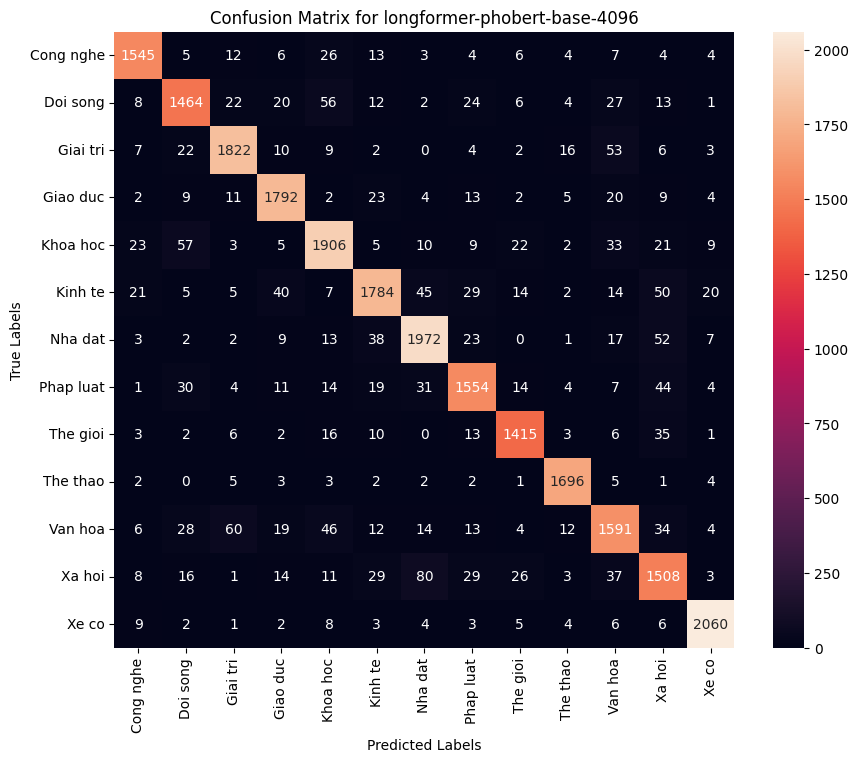

In [ ]:
class_names = ['Cong nghe', 'Doi song', 'Giai tri', 'Giao duc', 'Khoa hoc', 'Kinh te',
               'Nha dat', 'Phap luat', 'The gioi', 'The thao', 'Van hoa', 'Xa hoi', 'Xe co']

cm = confusion_matrix(real_values, predicts)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)


plt.title('Confusion Matrix for longformer-phobert-base-4096')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.savefig(path + 'confusion_matrix_longformer-phobert-base-4096.png')


In [ ]:
def check_wrong(real_values, predicts):
    wrong_arr = []
    wrong_label = []
    for i in range(len(predicts)):
        if predicts[i] != real_values[i]:
            wrong_arr.append(i)
            wrong_label.append(predicts[i])
    return wrong_arr, wrong_label

for i in range(15):
    print('-'*50)
    wrong_arr, wrong_label = check_wrong(real_values, predicts)
    print(test_df.iloc[wrong_arr[i]].processed_content)
    print(f'Predicted: ({class_names[wrong_label[i]]}) --vs-- Real label: ({class_names[real_values[wrong_arr[i]]]})')

--------------------------------------------------
biệt_đội chuột_lang đột_phá công_nghệ ndđt chuột_lang đạo_diễn đột_phá công_nghệ hình_ảnh chiều công_nghệ kỹ_xảo hàng_đầu phim kết_hợp tuyệt_vời diễn_xuất hình_ảnh hoạt_hình phim ra_mắt khán_giả việt_nam rạp toàn_quốc phim tựa gốc thể_loại hước xoay quanh câu_chuyện nhân_viên tình_báo chính_phủ biệt_đội chuột lang chuột chỉ_huy tài_ba chuột chuyên_gia vũ_khí chuột bậc thầy võ_thuật vẻ quyến_rũ cộng trinh_sát chuyên_gia máy_tính chuột_chũi mũi chuyến hành_trình gặp_gỡ vô_số thành_viên vương_quốc thú_vật chuột lang lang_thang gã chuột_đồng hung_dữ trang_bị thiết_bị tối_tân chuột lang huấn_luyện chuyên_nghiệp nắm vận_mệnh thế_giới đứng nguy_cơ giải_tán tồn_tại phim tham_gia tên_tuổi hollywood nicolas_cage penelope_cruz chuyên_gia kỹ_xảo điện_ảnh giải oscar đạo_diễn giành giải_oscar biệt_đội chuột_lang ứng_dụng công_nghệ kỹ_xảo dựng_hình chiều diễn_xuất chuột trở_nên sống_động hơn_bao_giờ_hết rạp công_nghệ_cao khán_giả nhân_vật lao thẳng m

In [ ]:
# Load model
models = []
for fold in range(skf.n_splits):
    model = NewsClassifier(n_classes=13)
    model.to(device)
    model.load_state_dict(torch.load(f'{path}phobert_fold{fold+1}.pth'))
    model.eval()
    models.append(model)

In [ ]:
def infer(text, tokenizer, models, class_names, max_len=512):
    encoded_review = tokenizer.encode_plus(
        text,
        max_length=max_len,
        truncation=True,
        add_special_tokens=True,
        padding='max_length',
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt',
    )

    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    # Taking the average of predictions from 5 models
    total_outs = []
    for model in models:
        model.eval()
        with torch.no_grad():
            output = model(input_ids, attention_mask)
            total_outs.append(output)

    total_outs = torch.stack(total_outs)
    mean_output = total_outs.mean(0)
    _, y_pred = torch.max(mean_output, dim=1)

    confidence_scores = mean_output.softmax(dim=1).cpu().numpy()

    # Create DataFrame with confidence scores
    df_confidence = pd.DataFrame(confidence_scores, columns=class_names)

    predicted_label = class_names[y_pred.item()]


    return df_confidence, predicted_label



In [ ]:

text = """
Dự án Trung tâm Nghiên cứu khoa học công nghệ hạt nhân (CNST) được thực hiện theo Hiệp định Liên Chính phủ ký năm 2011. Dự án đã được Chính phủ Việt Nam phê duyệt chủ trương đầu tư năm 2018. CNST dự kiến đặt tại TP Long Khánh, Đồng Nai. Trung tâm này sẽ có lò phản ứng hạt nhân dạng bể, công suất 10 MW, sử dụng nhiên liệu độ giàu thấp do Nga chế tạo. CNST tập trung lĩnh vực vật liệu chiếu xạ, khoa học sinh học, đồng vị phóng xạ, kỹ thuật lò phản ứng, an toàn bức xạ; nghiên cứu điều chế dược chất mới trong điều trị ung thư, nghiên cứu chiếu xạ silic - vật liệu bán dẫn, tán xạ góc nhỏ...

Ông Trần Chí Thành, Viện trưởng Viện Năng lượng nguyên tử (Bộ Khoa học và Công nghệ) cho biết "đây là lần đầu tiên Việt Nam triển khai một dự án về xây dựng lò phản ứng hạt nhân nghiên cứu công suất lớn".

Theo ông Thành, để triển khai Dự án CNST, Bộ Khoa học và Công nghệ đã có những phương án chuẩn bị nguồn nhân lực quản lý và triển khai ở các giai đoạn khác nhau. Bộ cũng đưa ra kế hoạch chuẩn bị nguồn nhân lực cho vận hành đảm bảo an toàn, khai thác hiệu quả Trung tâm sau khi đi vào hoạt động.

Để hỗ trợ thẩm tra, thẩm định Báo cáo nghiên cứu khả thi, Báo cáo phân tích an toàn và hồ sơ thiết kế, Bộ Khoa học và Công nghệ đề nghị Tập đoàn Năng lượng Nguyên tử Quốc gia Liên bang Nga (Rosatom) tạo điều kiện cho một số cán bộ Việt Nam tham gia thực hiện thiết kế cơ sở của lò phản ứng và các tính toán, phân tích an toàn đi kèm. Rosatom cũng giúp Việt Nam trong đào tạo cán bộ vận hành lò phản ứng nghiên cứu.

Viện Năng lượng nguyên tử Việt Nam cũng xây dựng các nhóm chuyên môn sâu về vật lý lò, thiết kế sử dụng kênh ngang, sản xuất đồng vị phóng xạ trên lò nghiên cứu, nghiên cứu vật liệu, chiếu xạ silic làm bán dẫn, nghiên cứu phân tích kích hoạt, bảo vệ môi trường, an toàn hạt nhân. Điều này nhằm xây dựng nguồn cán bộ nghiên cứu, ứng dụng khai thác hiệu quả lò nghiên cứu mới, đảm bảo an toàn khi CNST đi vào hoạt động

Trước đó tháng 10/2017, Viện ký thỏa thuận hợp tác với Trường Đại học nghiên cứu Bách khoa Tomsk và Đại học Nghiên cứu Hạt nhân Quốc gia Nga (MEPhI) vào tháng 12/2023, về hợp tác nghiên cứu và đào tạo cán bộ trong các lĩnh vực năng lượng nguyên tử có liên quan.

Viện trưởng Trần Chí Thành cho biết thêm, trước mắt Việt Nam và Nga sẽ tập trung đẩy mạnh triển khai thực hiện Dự án đảm bảo đúng tiến độ, hiệu quả, tuân thủ các quy định của Cơ quan Năng lượng nguyên tử quốc tế (IAEA).

Theo Quy hoạch phát triển, ứng dụng năng lượng nguyên tử giai đoạn 2021 - 2030, tầm nhìn 2050, hướng nghiên cứu ứng dụng năng lượng nguyên tử sẽ tập trung cả khoa học cơ bản (vật lý hạt nhân, vật lý lò, an toàn và thủy nhiệt, tự động điều khiển, vật liệu, hóa học ...) và ứng dụng trong y tế (y học bức xạ) nông nghiệp; công nghiệp; tài nguyên môi trường (nước ngầm, ô nhiễm, phát tán phóng xạ, xói mòn đất, chất thải phóng xạ, đuôi quặng)...

Ngoài ra, trong quy hoạch phát triển ứng dụng năng lượng nguyên tử giai đoạn tới sẽ nghiên cứu tiền khả thi dự án xây dựng tổ hợp máy gia tốc lớn đặt tại miền Bắc, xây dựng các phòng thí nghiệm công nghệ và an toàn hạt nhân...
"""
df_confidence, predicted_label = infer(text, tokenizer, models, class_names, max_len=512)

In [ ]:
df_confidence

,Cong nghe,Doi song,Giai tri,Giao duc,Khoa hoc,Kinh te,Nha dat,Phap luat,The gioi,The thao,Van hoa,Xa hoi,Xe co
0,0.000073,0.000441,0.000041,0.000231,0.998335,0.000164,0.000262,0.000062,0.000075,0.00003,0.000083,0.000145,0.000059


In [ ]:
print(f"Predicted label: {predicted_label}")

Predicted label: Khoa hoc
